In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import  pickle
from scipy.special import expit
import sklearn.model_selection as ms
from sklearn import preprocessing
from ipywidgets import interact, interactive, fixed, interact_manual

import seaborn as sns
from numba import jit

import statsmodels.api as statm
from IPython.display import display

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


import sys
sys.path.append("../libs")
from helpers import *
from esnlib import *
%matplotlib inline

/home/tronco/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# Predicción de Potencia Eólica en Plantas Chilenas 
### Nombre de memoria por definir


## Objetivos de la memoria
### Objetivo Principal
Proponer un modelo para el pronóstico de la potencia eolica generada a corto plazo (12 horas) según el artículo 7-13 punto a. de la Norma técnica de Seguridad y Calidad de Servido del CDECSIC.

### Objetivos Específicos
- Elegir un modelo clásico y dos modelos de redes de predicción de series de tiempo.
- Realizar una comparación entre los modelos.
- Validar el mejor modelo utilizando datos de plantas eólicas. Chilenas.


## Datos Utilizados

### Potencia Generada
Obtenidos del portal del CDECSIC https://sic.coordinadorelectrico.cl/informes-y-documentos/fichas/operacion-real/.

Cuenta con datos desde enero de 2008 a la actualidad con la potencia horaria real generada por cada planta.

(Potencia en **MWh**)

In [8]:
%%HTML
<iframe src="http://localhost:3000/dashboard-solo/db/potency-dashboard?orgId=1&from=1194150888709&to=1484321631736&panelId=1&theme=light" width="1000" height="400" frameborder="0"></iframe>

**No existen missing values** dentro de los datos, y de todas las series **se selecciono canela 1** ya que cuenta con la mayor cantidad de datos. 

### Datos Meteorológicos

Se buscaron otras fuentes de datos para complementar la serie de potencia generada, en especial se buscaron **datos meteorológicos reales o simulados** cercanos a **canela 1**.

Algunas fuentes de datos consultadas fueron:
- Campaña de medición del recurso eólico y solar (http://walker.dgf.uchile.cl/Mediciones/): Se encuentran mediciones realizadas en distintas estaciones a lo largo del pais.
    La estación más cercana a **canela 1** se encuentra en **La Cebada - costa** pero su última medición fue el **27-05-2007**
- Explorador de Energía Eólica (http://walker.dgf.uchile.cl/Explorador/Eolico2/): Sistema creado utilizando un modelo de modelamiento numérico NWP el año 2010 utilizando un sistema popular llamado  [Weather Research and Forecasting (WRF)](https://en.wikipedia.org/wiki/Weather_Research_and_Forecasting_Model). El explorador eólico permite descargar los datos utilizados para crear el modelo y además la predicción de la velocidad del viento hasta el **año 2013**
- Además **se enviaron correos** a las distintas generadoras pero sin respuesta alguna.

De todos los datos consultados se optó por utilizar sólamente los datos de la velocidad del viento obtenidos por la predicción del explorador eólico.

## Modelos Utilizados

Los modelos que se probaron fueron:
- Autoregressive Integrated Moving Average (ARIMA): Modelo estadistico clásico del análisis de serie de tiempo.
  $${\displaystyle Y_{t}=-(\Delta ^{d}Y_{t}-Y_{t})+\phi _{0}+\sum _{i=1}^{p}\phi _{i}\Delta ^{d}Y_{t-i}-\sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}+\varepsilon _{t}}$$
- Modelos de Redes Neuronales Recurrentes: **LSSTM** y **ESN**

## Experimentación

Métricas calculadas:
- Mean Square Error (MAE):
$${\displaystyle \operatorname {MAE} ={\frac {1}{n}}\sum _{i=1}^{n}(y_{i}-\hat{y}_{i})^{2}.}$$
- Mean Absolute Error (MAE):
$${\displaystyle \mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-\hat{y}_{i}\right|}{n}}={\frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}}.}$$
- Median Absolute Error (MeAE)
- Mean Absolute Percentage Error (MAPE):
$${\displaystyle {\mbox{M}}={\frac {100}{n}}\sum _{i=1}^{n}\left|{\frac {y_{i}-\hat{y}_{i}}{y_{i}}}\right|,}$$
- $R^2$:
$${\displaystyle \rho ^{2}=1-{{\sigma _{r}^{2}} \over {\sigma ^{2}}}}$$
### ARIMA

In [9]:
# Loading data
files = ["canela1.csv", "canela2.csv", "monte_redondo.csv"]
file = files[0]
data = pd.read_csv('../../data/'+file, names=["t","potency"],index_col="t")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
data.index=pd.to_datetime(data.index)

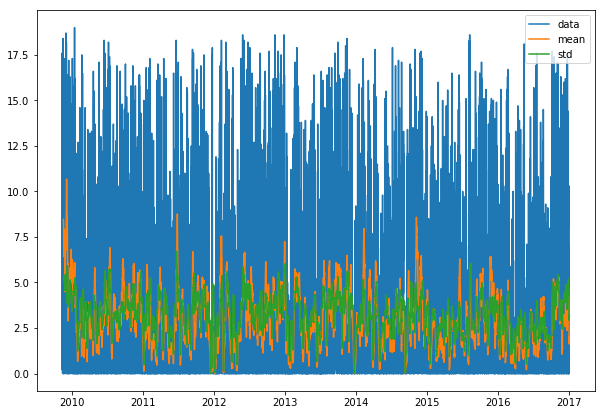

In [10]:
mean = data.rolling(window=200,center=False).mean()
std = data.rolling(window=200,center=False).std()

plt.figure(figsize=(10,7))
plt.plot(data)
plt.plot(mean)
plt.plot(std)
plt.legend(["data","mean", "std"])

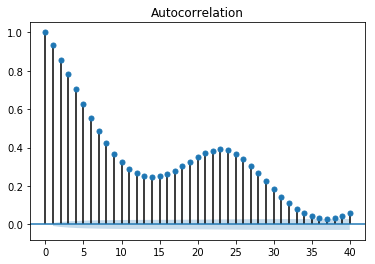

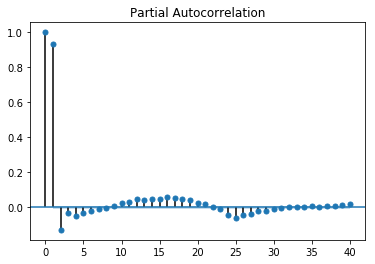

In [11]:
statm.graphics.tsa.plot_acf(data, lags=40)
statm.graphics.tsa.plot_pacf(data,lags=40)
print()

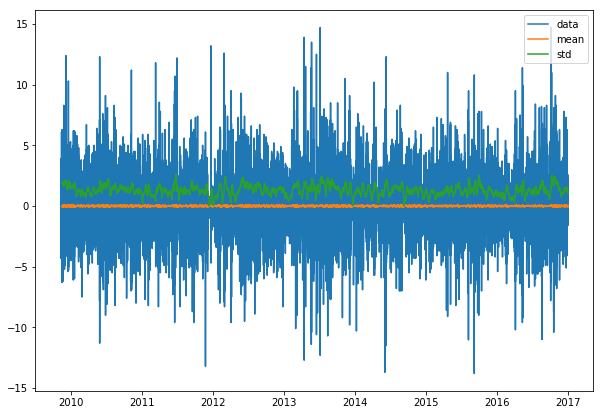

In [12]:
diff_data = pd.DataFrame(np.diff(data,axis=0))
diff_data.index = data.index[:-1]
mean = diff_data.rolling(window=200,center=False).mean()
std = diff_data.rolling(window=200,center=False).std()

plt.figure(figsize=(10,7))
plt.plot(diff_data)
plt.plot(mean)
plt.plot(std)
plt.legend(["data","mean", "std"])

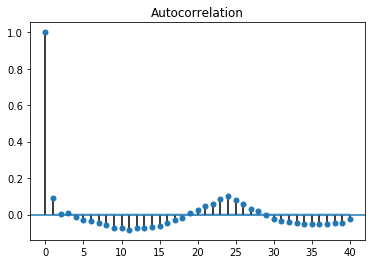

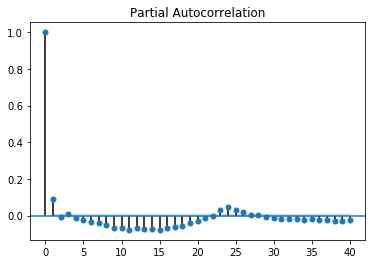

In [13]:
statm.graphics.tsa.plot_acf(diff_data, lags=40)
statm.graphics.tsa.plot_pacf(diff_data,lags=40)
print()

In [14]:
column_names = []
for i in range(1,13):
    if i < 10:
        column_names.append("$t+.{}$".format(i))
    else:
        column_names.append("$t+{}$".format(i))
y_pred = pd.read_csv("../../results/arima/canela1_y_approx.csv",names=column_names, skiprows=1)
y_test  = pd.read_csv("../../results/arima/canela1_y_test.csv",names=column_names, skiprows=1)

In [15]:
metrics_arima = show_errors(y_test,y_pred)
y_test_arima = y_test
y_pred_arima = y_pred
metrics_arima

,$t+0$,$t+1$,$t+2$,$t+3$,$t+4$,$t+5$,$t+6$,$t+7$,$t+8$,$t+9$,$t+10$,$t+11$,$\overline{t+i}$
MAE,1.158716,1.475529,1.730415,1.960648,2.162937,2.348644,2.507962,2.637591,2.747488,2.830040,2.892598,2.935075,2.282304
MSE,4.001310,6.131385,8.111235,10.055334,11.858632,13.588407,15.113355,16.480435,17.580603,18.465106,19.075876,19.498980,13.330055
MeAE,0.535997,0.722543,0.899997,1.015933,1.181296,1.300169,1.431281,1.528394,1.653989,1.700000,1.756674,1.820402,1.295556
MAPE,0.443568,0.564807,0.662309,0.750330,0.827583,0.898452,0.959134,1.008404,1.050089,1.081353,1.105000,1.120953,0.872665
$r^2$,0.678758,0.507739,0.348778,0.192699,0.047974,-0.090820,-0.212972,-0.322300,-0.410099,-0.480757,-0.529560,-0.563264,-0.069485


## Modelos de Redes Recurrentes

### Parámetros utilizados

#### ESN
- Reservoir Size: 1000 neuronas
- Sparsity $0,0.5,0.9$
- Regularization: $0,1e-5,1,2$
- Spectral Radius : $1e-8,0.1,1,2$
- Activation Functions: $tanh$, $sigmoid$

#### LSTM
- Node number: $5,10,15,20$
- Optimizer: Stochastic gradient descent, ADAM, ADADELTA.
- Epochs: 10

### Data Split
#### Train vs Test
Se utilizaron $80\%$ de los datos para $Train$ y $20\%$ para $Test$ así se tiene alrededor de **10 meses de datos en el conjunto de $Test$**

#### Cross Validation
Usando 5-fold Time Series Cross validation.

<img src="https://i.stack.imgur.com/fXZ6k.png"/>
### Univariado

In [16]:
#ESN Gridsearch Params
n_reservoir = 1000
sparsity = [0,0.5,0.9]
leaking_rate = [1,0.5,0.1]
regularization= [0,1e-5,1,2]
spectral_radius= [1e-8,0.1,1,2]
activation = [np.tanh,expit]
param_grid = {"n_reservoir":[n_reservoir], "sparsity":sparsity, "leaking_rate":leaking_rate, "regularization":regularization, "activation": activation, "spectral_radius":spectral_radius}
params = ms.ParameterGrid(param_grid)

In [17]:
#LSTM Gridsearch Params
lstm_nodes = [5,10,15,20]
optimizer = ["sgd", "adam","adadelta"]
loss = ["mean_squared_error"]
dims = data.shape[1] if len(data.shape) > 1 else 1
input_dim = [10]
param_grid = {"nodes":lstm_nodes, "optimizer":optimizer, "loss":loss, "input_dim":input_dim}
lstm_params = ms.ParameterGrid(param_grid)

In [18]:
# Reading Validation scores
scores_6_lags = pd.read_csv("../../results/esn/scores_uni_6.csv", index_col=0, names=["f0","f1","f2","f3","f3"])
scores_12_lags = pd.read_csv("../../results/esn/scores_uni_12.csv", index_col=0, names=["f0","f1","f2","f3","f3"])
scores_24_lags = pd.read_csv("../../results/esn/scores_uni_24.csv", index_col=0, names=["f0","f1","f2","f3","f3"])

lstm_scores_6_lags = pd.read_csv("../../results/lstm/scores_uni_6.csv", index_col=0, names=["f0","f1","f2","f3","f3"])
lstm_scores_12_lags = pd.read_csv("../../results/lstm/scores_uni_12.csv", index_col=0, names=["f0","f1","f2","f3","f3"])
lstm_scores_24_lags = pd.read_csv("../../results/lstm/scores_uni_24.csv", index_col=0, names=["f0","f1","f2","f3","f3"])

In [19]:
scores_6_mean = scores_6_lags.mean(axis=1)
scores_12_mean = scores_12_lags.mean(axis=1)
scores_24_mean = scores_24_lags.mean(axis=1)

lstm_scores_6_mean = lstm_scores_6_lags.mean(axis=1)
lstm_scores_12_mean = lstm_scores_12_lags.mean(axis=1)
lstm_scores_24_mean = lstm_scores_24_lags.mean(axis=1)

In [20]:
best_val_6 = scores_6_mean.argmin()
best_val_12 = scores_12_mean.argmin()
best_val_24 = scores_24_mean.argmin()

lstm_best_val_6 = lstm_scores_6_mean.argmin()
lstm_best_val_12 = lstm_scores_12_mean.argmin()
lstm_best_val_24 = lstm_scores_24_mean.argmin()

In [21]:
best_params = [(6,best_val_6,lstm_best_val_6), (12,best_val_12,lstm_best_val_6), (24, best_val_24,lstm_best_val_6)]

In [22]:
def create_lstm(input_dim,nodes,loss='mean_squared_error',optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nodes, input_dim=input_dim))
    model.add(Dense(12))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [23]:
metrics_esn = dict()
metrics_lstm = dict()
prediction_steps = 12
train_perc = 0.8

for input_steps, best_val,lstm_best_val in best_params:
    data = pd.Series.from_csv('../../data/canela1.csv')
    X,y = getDataWindowed(data,input_steps,prediction_steps)

    trainlen = int(train_perc*len(X))
    X_train,X_test = X[:trainlen], X[trainlen:]
    y_train,y_test = y[:trainlen], y[trainlen:]

    #Preprocess data
    print("Preprocessing Data")
    minmax_in = preprocessing.MinMaxScaler(feature_range=(0,1))
    minmax_out = preprocessing.MinMaxScaler(feature_range=(0,1))

    minmax_in.fit(X_train)
    minmax_out.fit(y_train)
    preproc_in = minmax_in
    preproc_out = minmax_out

    X_train = preproc_in.transform(X_train) if preproc_in else X_train
    X_test = preproc_in.transform(X_test) if preproc_in else X_test

    y_train = preproc_out.transform(y_train) if preproc_out else y_train
    # Training ESN
    print("Training ESN")
    clf = ESN(random_state=42,**params[best_val])
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test,cont=True)
    y_pred = preproc_out.inverse_transform(y_pred)
    
    metric = show_errors(y_test,y_pred)
    metrics_esn[input_steps] = (metric,y_test,y_pred)
    
    #Training LSTM
    print("Training LSTM")
    X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))
    model = create_lstm(input_steps,nodes=lstm_params[lstm_best_val]["nodes"],loss=lstm_params[lstm_best_val]["loss"], optimizer=lstm_params[lstm_best_val]["optimizer"])
    model.fit(X_train,y_train,epochs=10,verbose=0)
    y_pred = model.predict(X_test)
    y_pred = preproc_out.inverse_transform(y_pred)
    
    metric = show_errors(y_test,y_pred)
    metrics_lstm[input_steps] = (metric,y_test,y_pred)

Preprocessing Data
Training ESN
Training LSTM


/home/tronco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tronco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(None, 6))`
  This is separate from the ipykernel package so we can avoid doing imports until


Preprocessing Data
Training ESN
Training LSTM


/home/tronco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(None, 12))`
  This is separate from the ipykernel package so we can avoid doing imports until


Preprocessing Data
Training ESN
Training LSTM


/home/tronco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(None, 24))`
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
metrics_esn_uni = metrics_esn 
metrics_lstm_uni = metrics_lstm

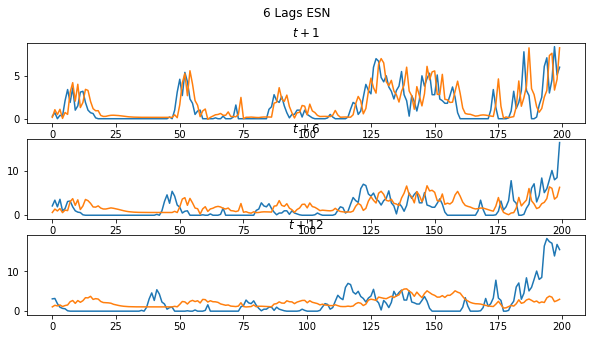

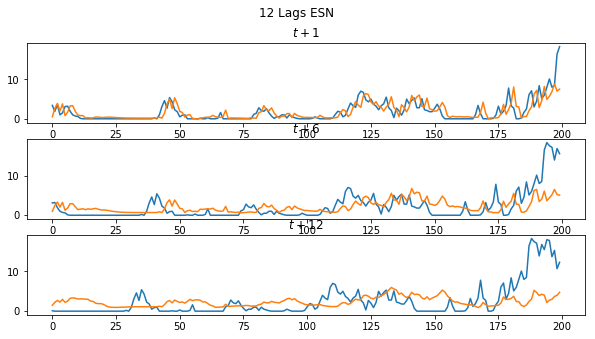

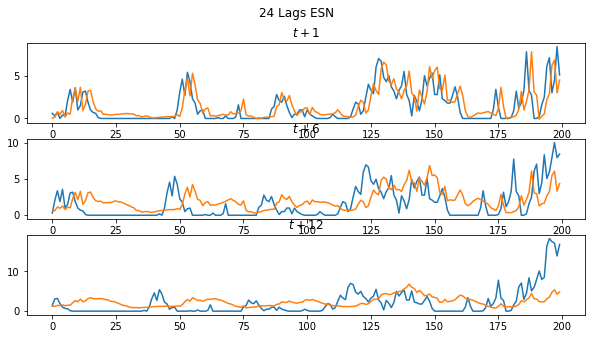

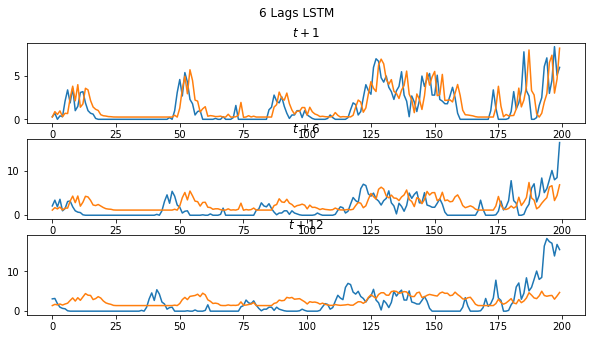

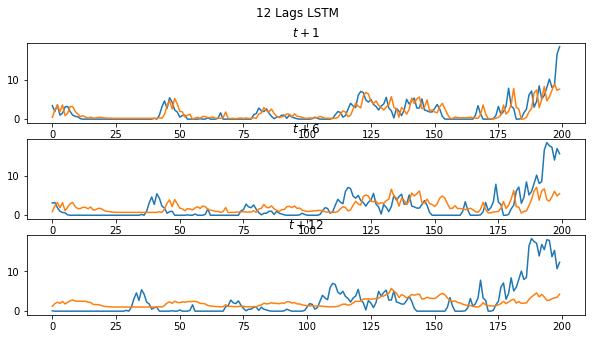

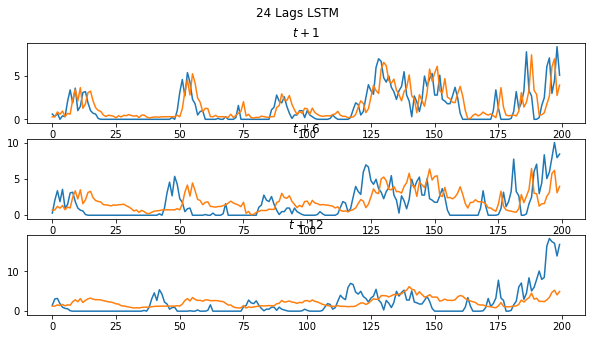

In [25]:
for key in metrics_esn_uni:
    _, y_test,y_pred = metrics_esn_uni[key]
    fig,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(10,5))
    fig.suptitle("{} Lags ESN".format(key))
    ax1.plot(y_test[:200,0])
    ax1.plot(y_pred[:200,0])
    ax1.set_title("$t+1$")
    ax2.plot(y_test[:200,5])
    ax2.plot(y_pred[:200,5])
    ax2.set_title("$t+6$")
    ax3.plot(y_test[:200,11])
    ax3.plot(y_pred[:200,11])
    ax3.set_title("$t+12$")
    plt.show()
for key in metrics_lstm_uni:
    _, y_test,y_pred = metrics_lstm_uni[key]
    fig,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(10,5))
    fig.suptitle("{} Lags LSTM".format(key))
    ax1.plot(y_test[:200,0])
    ax1.plot(y_pred[:200,0])
    ax1.set_title("$t+1$")
    ax2.plot(y_test[:200,5])
    ax2.plot(y_pred[:200,5])
    ax2.set_title("$t+6$")
    ax3.plot(y_test[:200,11])
    ax3.plot(y_pred[:200,11])
    ax3.set_title("$t+12$")
    plt.show()

In [26]:
result = dict()
column_names = []
for i in range(12):
    column_names.append("$t+{}$".format(i+1))

In [27]:
def show_metric_uni(metric_name="MSE"):
    result = dict()
    column_names = []
    for i in range(12):
        column_names.append("$t+{}$".format(i+1))
    column_names.append("$\overline{t+i}$")
    for key in metrics_esn_uni:
        metric = metrics_esn_uni[key][0]
        values = metric.loc[metric_name].values
        result["{}lags-ESN".format(key)] = values
    for key in metrics_lstm_uni:
        metric = metrics_lstm_uni[key][0]
        values = metric.loc[metric_name].values
        result["{}lags-LSTM".format(key)] = values
    result["arima"] = metrics_arima.loc[metric_name].values
    result_df = pd.DataFrame.from_dict(result,orient="index")
    result_df.columns = column_names
    return result_df[column_names[::5]]

In [28]:
interact(show_metric_uni, metric_name=["MSE","MAE","MeAE", "MAPE","$r^2$"])

A Jupyter Widget

<function __main__.show_metric_uni>

## Potencia + Velocidad del Viento (WRF)

In [29]:
#Gridsearch Params
n_reservoir = 1000
sparsity = [0,0.5,0.9]
leaking_rate = [1,0.5,0.1]
regularization= [0,1e-5,1,2]
spectral_radius= [1e-8,0.1,1,2]
activation = [np.tanh,expit]
param_grid = {"n_reservoir":[n_reservoir], "sparsity":sparsity, "leaking_rate":leaking_rate, "regularization":regularization, "activation": activation, "spectral_radius":spectral_radius}
params = ms.ParameterGrid(param_grid)

In [30]:
#LSTM Gridsearch Params
lstm_nodes = [5,10,15,20]
optimizer = ["sgd", "adam","adadelta"]
loss = ["mean_squared_error"]
dims = data.shape[1] if len(data.shape) > 1 else 1
input_dim = [input_steps*dims]
param_grid = {"nodes":lstm_nodes, "optimizer":optimizer, "loss":loss, "input_dim":input_dim}
lstm_params = ms.ParameterGrid(param_grid)

In [31]:
# Reading Validation scores
scores_6_lags = pd.read_csv("../../results/esn/scores_merged_6.csv", index_col=0, names=["f0","f1","f2","f3","f3"])
scores_12_lags = pd.read_csv("../../results/esn/scores_merged_12.csv", index_col=0, names=["f0","f1","f2","f3","f3"])
scores_24_lags = pd.read_csv("../../results/esn/scores_merged_24.csv", index_col=0, names=["f0","f1","f2","f3","f3"])

lstm_scores_6_lags = pd.read_csv("../../results/lstm/scores_merged_6.csv", index_col=0, names=["f0","f1","f2","f3","f3"])
lstm_scores_12_lags = pd.read_csv("../../results/lstm/scores_merged_12.csv", index_col=0, names=["f0","f1","f2","f3","f3"])
lstm_scores_24_lags = pd.read_csv("../../results/lstm/scores_merged_24.csv", index_col=0, names=["f0","f1","f2","f3","f3"])

In [32]:
scores_6_mean = scores_6_lags.mean(axis=1)
scores_12_mean = scores_12_lags.mean(axis=1)
scores_24_mean = scores_24_lags.mean(axis=1)

lstm_scores_6_mean = lstm_scores_6_lags.mean(axis=1)
lstm_scores_12_mean = lstm_scores_12_lags.mean(axis=1)
lstm_scores_24_mean = lstm_scores_24_lags.mean(axis=1)

In [33]:
best_val_6 = scores_6_mean.argmin()
best_val_12 = scores_12_mean.argmin()
best_val_24 = scores_24_mean.argmin()

lstm_best_val_6 = lstm_scores_6_mean.argmin()
lstm_best_val_12 = lstm_scores_12_mean.argmin()
lstm_best_val_24 = lstm_scores_24_mean.argmin()

In [34]:
best_params = [(6,best_val_6,lstm_best_val_6), (12,best_val_12,lstm_best_val_6), (24, best_val_24,lstm_best_val_6)]

In [35]:
metrics_esn = dict()
metrics_lstm = dict()
prediction_steps = 12
train_perc = 0.8

for input_steps, best_val,lstm_best_val in best_params:
    data = pd.read_csv('../../data/canela1_merged.csv',index_col=0).values
    X,y = getDataWindowed(data,input_steps,prediction_steps)

    trainlen = int(train_perc*len(X))
    X_train,X_test = X[:trainlen], X[trainlen:]
    y_train,y_test = y[:trainlen], y[trainlen:]

    #Preprocess data
    print("Preprocessing Data")
    minmax_in = preprocessing.MinMaxScaler(feature_range=(0,1))
    minmax_out = preprocessing.MinMaxScaler(feature_range=(0,1))

    minmax_in.fit(X_train)
    minmax_out.fit(y_train)
    preproc_in = minmax_in
    preproc_out = minmax_out

    X_train = preproc_in.transform(X_train) if preproc_in else X_train
    X_test = preproc_in.transform(X_test) if preproc_in else X_test

    y_train = preproc_out.transform(y_train) if preproc_out else y_train
    # Training ESN
    print("Training ESN")
    clf = ESN(random_state=42,**params[best_val])
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test,cont=True)
    y_pred = preproc_out.inverse_transform(y_pred)
    
    metric = show_errors(y_test,y_pred)
    metrics_esn[input_steps] = (metric,y_test,y_pred)
    
    #Training LSTM
    print("Training LSTM")
    X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))
    model = create_lstm(input_steps*2,nodes=lstm_params[lstm_best_val]["nodes"],loss=lstm_params[lstm_best_val]["loss"], optimizer=lstm_params[lstm_best_val]["optimizer"])
    model.fit(X_train,y_train,epochs=10,verbose=0)
    y_pred = model.predict(X_test)
    y_pred = preproc_out.inverse_transform(y_pred)
    
    metric = show_errors(y_test,y_pred)
    metrics_lstm[input_steps] = (metric,y_test,y_pred)

Preprocessing Data
Training ESN
Training LSTM


/home/tronco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tronco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(None, 12))`
  This is separate from the ipykernel package so we can avoid doing imports until


Preprocessing Data
Training ESN
Training LSTM


/home/tronco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(None, 24))`
  This is separate from the ipykernel package so we can avoid doing imports until


Preprocessing Data
Training ESN
Training LSTM


/home/tronco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(None, 48))`
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
metrics_esn_multi = metrics_esn
metrics_lstm_multi = metrics_lstm

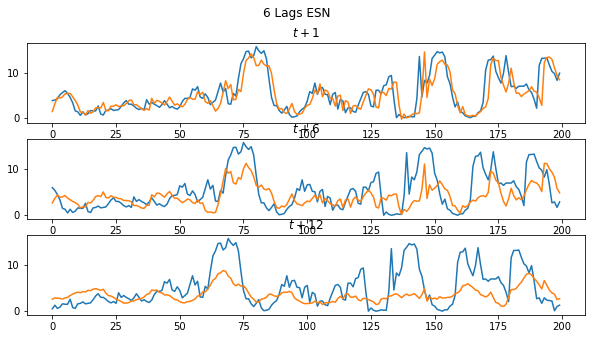

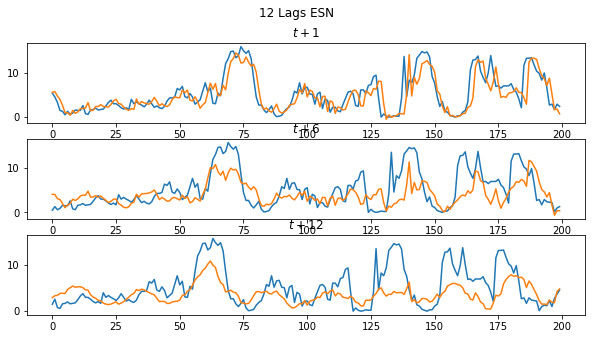

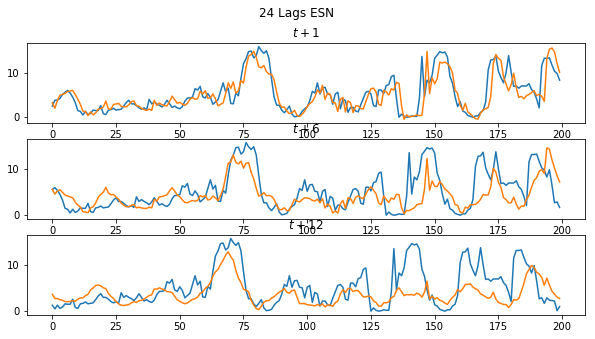

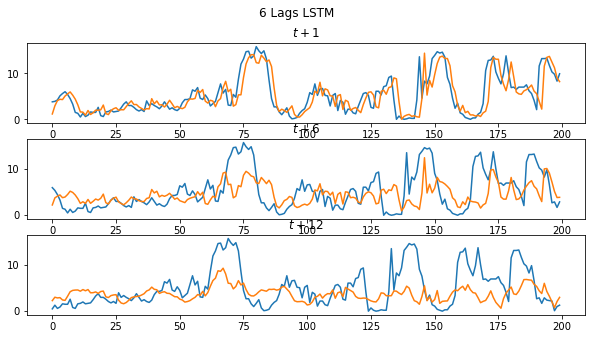

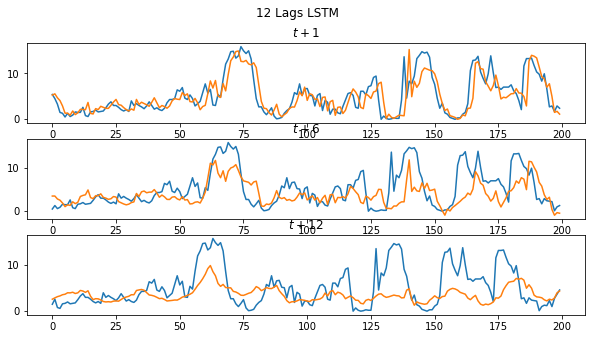

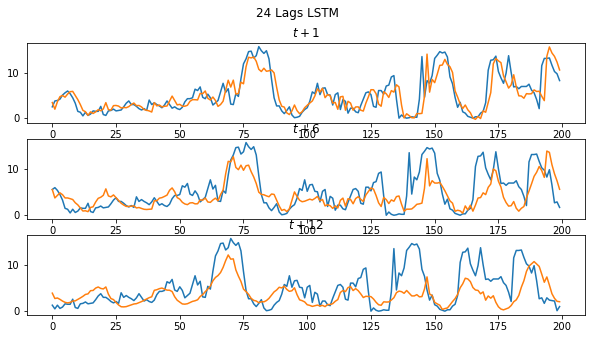

In [37]:
for key in metrics_esn_multi:
    _, y_test,y_pred = metrics_esn_multi[key]
    fig,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(10,5))
    fig.suptitle("{} Lags ESN".format(key))
    ax1.plot(y_test[:200,0])
    ax1.plot(y_pred[:200,0])
    ax1.set_title("$t+1$")
    ax2.plot(y_test[:200,5])
    ax2.plot(y_pred[:200,5])
    ax2.set_title("$t+6$")
    ax3.plot(y_test[:200,11])
    ax3.plot(y_pred[:200,11])
    ax3.set_title("$t+12$")
    plt.show()
for key in metrics_lstm_multi:
    _, y_test,y_pred = metrics_lstm_multi[key]
    fig,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(10,5))
    fig.suptitle("{} Lags LSTM".format(key))
    ax1.plot(y_test[:200,0])
    ax1.plot(y_pred[:200,0])
    ax1.set_title("$t+1$")
    ax2.plot(y_test[:200,5])
    ax2.plot(y_pred[:200,5])
    ax2.set_title("$t+6$")
    ax3.plot(y_test[:200,11])
    ax3.plot(y_pred[:200,11])
    ax3.set_title("$t+12$")
    plt.show()

In [41]:
def show_metric_multi(metric_name="MSE"):
    result = dict()
    column_names = []
    for i in range(12):
        column_names.append("$t+{}$".format(i+1))
    column_names.append("$\overline{t+i}$")
    for key in metrics_esn_multi:
        metric = metrics_esn_multi[key][0]
        values = metric.loc[metric_name].values
        result["{}lags-ESN".format(key)] = values
    for key in metrics_lstm_multi:
        metric = metrics_lstm_multi[key][0]
        values = metric.loc[metric_name].values
        result["{}lags-LSTM".format(key)] = values
    result["arima"] = metrics_arima.loc[metric_name].values
    result_df = pd.DataFrame.from_dict(result,orient="index")
    result_df.columns = column_names
    return result_df[column_names[::5]]

In [42]:
interact(show_metric_multi, metric_name=["MSE","MAE","MeAE", "MAPE","$r^2$"])

A Jupyter Widget

<function __main__.show_metric_multi>

In [43]:
interact(show_metric_uni, metric_name=["MSE","MAE","MeAE", "MAPE","$r^2$"])

A Jupyter Widget

<function __main__.show_metric_uni>